In [2]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import Counter
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

/home/rakib/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
[nltk_data] Downloading package punkt to /home/rakib/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/rakib/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/rakib/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import pandas as pd

# Load the dataset
df = pd.read_csv("responses.csv")


In [4]:
column_mapping = {
    'Full Name (please use your FRA-UAS name if possible)': 'name',
    'Email Address (please use your FRA-UAS email address if possible)': 'email',
    'Please confirm the version of ChatGPT you used for this task.': 'version',
    'Do you consent to participate in this study?': 'consent',
    'Are you 18 years of age or older?': 'adult',
    'Gender': 'gender',
    'Age': 'age',
    'Nationality': 'nationality',
    'Academic Degree': 'academic_degree',
    'Occupation': 'occupation',
    'Which AI code generation tools have you used?': 'ai_tools',
    'Have you used AI tools before, and how often?': 'often_use',
    'What is your English proficiency level?': 'eng_proficiency',
    'Please confirm that you have read and understood the instructions.': 'confirm',
    'Your Prompt for Task 1': 'prompt1',
    'ChatGPT’s Response to Your Prompt (Task 1)': 'response1',
    'Comment (Task 1)': 'comment1',
    'Your Prompt for Task 2': 'prompt2',
    'ChatGPT’s Response to Your Prompt (Task 2)': 'response2',
    'Comment (Task 2)': 'comment2',
    'Your Prompt for Task 3': 'prompt3',
    'ChatGPT’s Response to Your Prompt (Task 3)': 'response3',
    'Comment (Task 3)': 'comment3',
    'I fear artificial intelligence.': 'fear_ai',
    'I trust artificial intelligence.': 'trust_ai',
    'Artificial intelligence will destroy humankind.': 'destroy_humankind',
    'Artificial intelligence will benefit humankind.': 'benefit_humankind',
    'Artificial intelligence will cause many job losses.': 'job_losses',
    'How much effort did you put into thinking about the wording of your prompts?': 'effort_prompts',
    'How reflected was the output you received from your prompts?': 'reflected_prompts',
    'How confident were you that your prompts would achieve the desired result?': 'confident_to_achieve_prompts_desired_result',
    'Was anything difficult for you while writing the prompts?': 'difficult_while_writing_prompts',
    'What would you change to make the tasks easier or better?': 'change_to_make_the_tasks',
    'Did you try different ways of asking the AI? ': 'try_different_ways',
    'Please explain your answer. Why or why not?': 'why_not'
}

df.rename(columns=column_mapping, inplace=True)

# print column names
print(df.columns)

Index(['Timestamp', 'name', 'email', 'version', 'consent', 'adult', 'gender',
       'age', 'nationality', 'Academic Degree ', 'occupation', 'ai_tools',
       'often_use', 'eng_proficiency', 'confirm', 'prompt1', 'response1',
       'comment1', 'prompt2', 'response2', 'comment2', 'prompt3', 'response3',
       'comment3', 'fear_ai', 'trust_ai', 'destroy_humankind',
       'benefit_humankind', 'job_losses', 'effort_prompts',
       'reflected_prompts', 'confident_to_achieve_prompts_desired_result',
       'difficult_while_writing_prompts', 'change_to_make_the_tasks',
       'try_different_ways', 'why_not'],
      dtype='object')


In [5]:
# Auto-detect the email column
email_col = [c for c in df.columns if "email" in c.lower()][0]

# Drop duplicates based on that column
df = df.drop_duplicates(subset=[email_col], keep="first")

print("Using email column:", email_col)
print("Final shape:", df.shape)


Using email column: email
Final shape: (54, 36)


In [6]:
## Check and handle missing values(fill with mean for numerical columns, mode for categorical)

In [7]:
print(df.isnull().sum())

Timestamp                                       0
name                                            0
email                                           0
version                                         0
consent                                         0
adult                                           0
gender                                          0
age                                             0
nationality                                     0
Academic Degree                                 0
occupation                                      0
ai_tools                                        0
often_use                                       0
eng_proficiency                                 0
confirm                                         0
prompt1                                         0
response1                                       0
comment1                                       34
prompt2                                         0
response2                                       0


In [8]:
# Female and Male Total Count

In [9]:

# Count gender occurrences
gender_counts = df['gender'].value_counts().reset_index()
gender_counts.columns = ['Gender', 'Count']

print(gender_counts)

   Gender  Count
0    Male     37
1  Female     17


In [10]:
## Compute descriptive statistics

In [13]:
descriptive_stats = df[['fear_ai', 'trust_ai', 'destroy_humankind','benefit_humankind', 'job_losses', 'effort_prompts',
       'reflected_prompts', 'confident_to_achieve_prompts_desired_result']].describe()
# Apply formatting to each element in the DataFrame
descriptive_stats = descriptive_stats.map(lambda x: f'{x:.3f}')
print("Descriptive Statistics:\n", descriptive_stats)

Descriptive Statistics:
       fear_ai trust_ai destroy_humankind benefit_humankind job_losses  \
count  54.000   54.000            54.000            54.000     54.000   
mean    3.815    6.019             4.500             7.241      6.722   
std     3.047    2.319             3.208             1.990      2.422   
min     0.000    0.000             0.000             1.000      0.000   
25%     1.000    5.000             2.000             6.000      5.250   
50%     3.500    6.500             4.000             7.000      7.000   
75%     6.000    8.000             7.000             8.750      8.000   
max    10.000   10.000            10.000            10.000     10.000   

      effort_prompts reflected_prompts  \
count         54.000            54.000   
mean           3.426             3.852   
std            1.126             0.627   
min            1.000             3.000   
25%            3.000             3.000   
50%            4.000             4.000   
75%            4.000   

In [14]:
# Analyze correlations variables

In [16]:
correlation_matrix = df[['fear_ai', 'trust_ai', 'destroy_humankind','benefit_humankind', 'job_losses', 'effort_prompts',
       'reflected_prompts', 'confident_to_achieve_prompts_desired_result']].corr()

# Apply formatting to each element in the DataFrame
formatted_correlation_matrix = correlation_matrix.map(lambda x: f'{x:.3f}')
print("\nCorrelation Matrix:\n", formatted_correlation_matrix)


Correlation Matrix:
                                             fear_ai trust_ai  \
fear_ai                                       1.000    0.115   
trust_ai                                      0.115    1.000   
destroy_humankind                             0.581    0.141   
benefit_humankind                            -0.322    0.302   
job_losses                                    0.121   -0.053   
effort_prompts                               -0.081   -0.010   
reflected_prompts                            -0.044    0.275   
confident_to_achieve_prompts_desired_result  -0.154    0.061   

                                            destroy_humankind  \
fear_ai                                                 0.581   
trust_ai                                                0.141   
destroy_humankind                                       1.000   
benefit_humankind                                      -0.084   
job_losses                                              0.429   
effort_prom

In [18]:
## Correlation heatmap

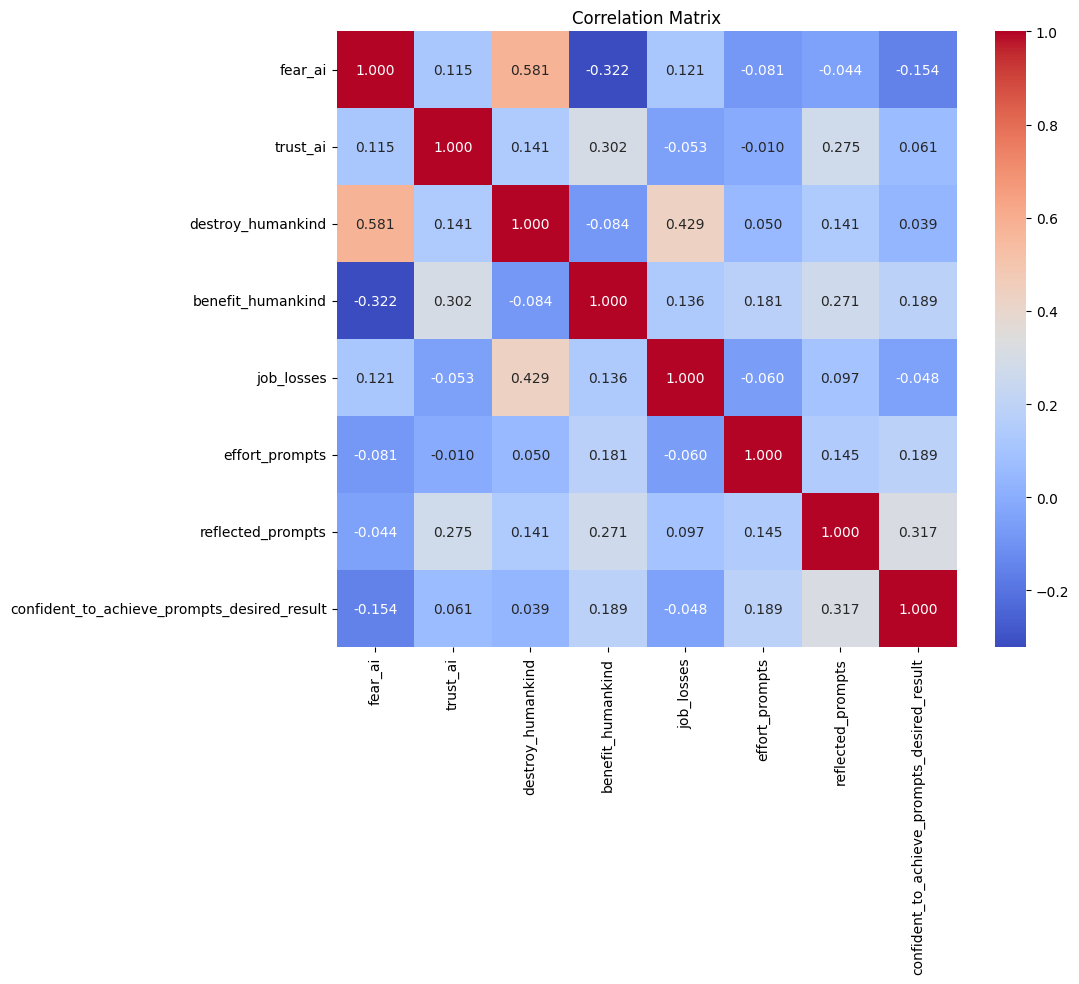

In [19]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.3f')
plt.title('Correlation Matrix')
plt.show()

In [84]:
## Compare effectiveness prompt by gender

In [85]:
gender_comparison = df.groupby('gender')[['effort_prompts', 'reflected_prompts']].mean()
print("\nEffectiveness Ratings by gender:\n", gender_comparison)


Effectiveness Ratings by gender:
         effort_prompts  reflected_prompts
gender                                   
Female        3.117647           3.823529
Male          3.567568           3.864865


In [86]:
# Trust In AI

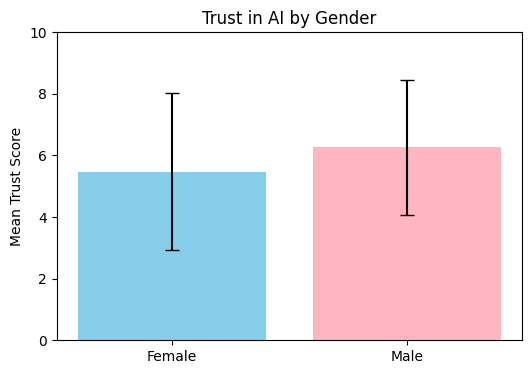

(   gender      mean       std  count
 0  Female  5.470588  2.552392     17
 1    Male  6.270270  2.194041     37,
 np.float64(1.1813822973874313),
 np.float64(0.24282582202105626))

In [87]:
import matplotlib.pyplot as plt
from scipy import stats

# Select relevant columns
trust_data = df[['gender', 'trust_ai']].dropna()

# Convert to numeric (in case some are strings)
trust_data['trust_ai'] = pd.to_numeric(trust_data['trust_ai'], errors='coerce')

# Group by gender and calculate mean & std
gender_means = trust_data.groupby('gender')['trust_ai'].agg(['mean', 'std', 'count']).reset_index()

# Perform t-test
male_scores = trust_data[trust_data['gender'] == 'Male']['trust_ai']
female_scores = trust_data[trust_data['gender'] == 'Female']['trust_ai']
t_stat, p_val = stats.ttest_ind(male_scores, female_scores, nan_policy='omit')

# Plot
plt.figure(figsize=(6,4))
plt.bar(gender_means['gender'], gender_means['mean'], yerr=gender_means['std'], capsize=5, color=['skyblue', 'lightpink'])
plt.ylabel('Mean Trust Score')
plt.title('Trust in AI by Gender')
plt.ylim(0, 10)
plt.show()

gender_means, t_stat, p_val


In [88]:
# Fear AI

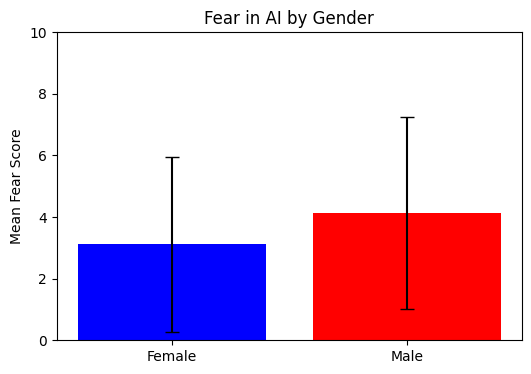

(   gender      mean       std  count
 0  Female  3.117647  2.847858     17
 1    Male  4.135135  3.119492     37,
 np.float64(1.1428745238322437),
 np.float64(0.2583254209602944))

In [89]:
import matplotlib.pyplot as plt
from scipy import stats

# Select relevant columns
trust_data = df[['gender', 'fear_ai']].dropna()

# Convert to numeric (in case some are strings)
trust_data['fear_ai'] = pd.to_numeric(trust_data['fear_ai'], errors='coerce')

# Group by gender and calculate mean & std
gender_means = trust_data.groupby('gender')['fear_ai'].agg(['mean', 'std', 'count']).reset_index()

# Perform t-test
male_scores = trust_data[trust_data['gender'] == 'Male']['fear_ai']
female_scores = trust_data[trust_data['gender'] == 'Female']['fear_ai']
t_stat, p_val = stats.ttest_ind(male_scores, female_scores, nan_policy='omit')

# Plot
plt.figure(figsize=(6,4))
plt.bar(gender_means['gender'], gender_means['mean'], yerr=gender_means['std'], capsize=5, color=['blue', 'red'])
plt.ylabel('Mean Fear Score')
plt.title('Fear in AI by Gender')
plt.ylim(0, 10)
plt.show()

gender_means, t_stat, p_val

In [95]:
# Frequency counts

In [96]:
from collections import Counter

# Combine all tokenized prompts
all_tokens = df['Prompt1_tokens'].sum() + df['Prompt2_tokens'].sum() + df['Prompt3_tokens'].sum()

# Count word frequencies
overall_freq = Counter(all_tokens)

# Show top 20 most common words
print("Top 20 Words (All Prompts):")
print(overall_freq.most_common(20))


Top 20 Words (All Prompts):
[('dream', 71), ('plan', 70), ('like', 65), ('want', 64), ('year', 62), ('2025', 61), ('germany', 58), ('write', 54), ('home', 53), ('’', 50), ('house', 46), ('vacation', 43), ('essay', 40), ('price', 37), ('would', 36), ('also', 35), ('great', 31), ('days', 29), ('2', 27), ('feel', 26)]


In [97]:
# Prompt1
prompt1_freq = Counter(df['Prompt1_tokens'].sum())
print("\nTop 10 Words in Prompt1:")
print(prompt1_freq.most_common(10))

# Prompt2
prompt2_freq = Counter(df['Prompt2_tokens'].sum())
print("\nTop 10 Words in Prompt2:")
print(prompt2_freq.most_common(10))

# Prompt3
prompt3_freq = Counter(df['Prompt3_tokens'].sum())
print("\nTop 10 Words in Prompt3:")
print(prompt3_freq.most_common(10))



Top 10 Words in Prompt1:
[('year', 61), ('2025', 55), ('write', 40), ('essay', 37), ('feel', 21), ('like', 21), ('also', 18), ('’', 16), ('new', 16), ('challenges', 15)]

Top 10 Words in Prompt2:
[('home', 51), ('germany', 50), ('dream', 46), ('house', 46), ('price', 36), ('like', 28), ('want', 25), ('garden', 22), ('possible', 21), ('room', 18)]

Top 10 Words in Prompt3:
[('plan', 68), ('vacation', 43), ('want', 33), ('great', 30), ('’', 29), ('days', 29), ('dream', 25), ('2-week', 23), ('2', 23), ('week', 23)]


In [98]:
# Group by gender and sum all tokens per gender
male_tokens = df[df['gender'] == 'Male'][['Prompt1_tokens', 'Prompt2_tokens', 'Prompt3_tokens']].sum().sum()
female_tokens = df[df['gender'] == 'Female'][['Prompt1_tokens', 'Prompt2_tokens', 'Prompt3_tokens']].sum().sum()

male_freq = Counter(male_tokens)
female_freq = Counter(female_tokens)

print("\nTop 10 Words Used by Males:")
print(male_freq.most_common(10))

print("\nTop 10 Words Used by Females:")
print(female_freq.most_common(10))



Top 10 Words Used by Males:
[('like', 48), ('dream', 47), ('plan', 46), ('want', 41), ('germany', 39), ('house', 38), ('home', 37), ('year', 35), ('2025', 35), ('write', 34)]

Top 10 Words Used by Females:
[('year', 27), ('2025', 26), ('dream', 24), ('plan', 24), ('want', 23), ('write', 20), ('germany', 19), ('like', 17), ('’', 16), ('home', 16)]


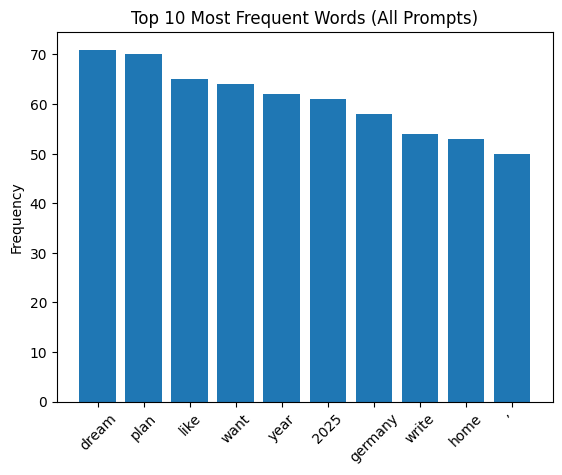

In [99]:
import matplotlib.pyplot as plt

# Pick one (e.g., overall_freq)
top_words = overall_freq.most_common(10)
words, counts = zip(*top_words)

plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title("Top 10 Most Frequent Words (All Prompts)")
plt.ylabel("Frequency")
plt.show()


In [100]:
# Lexical diversity measures

In [101]:
from lexical_diversity import lex_div as ld

def get_lexical_measures(tokens_list):
    flat_tokens = [token for tokens in tokens_list for token in tokens]
    return {
        'TTR': ld.ttr(flat_tokens),
        'MTLD': ld.mtld(flat_tokens),
        'HDD': ld.hdd(flat_tokens)
    }

# Collect tokens by gender
male_tokens_all = df[df['gender'] == 'Male'][['Prompt1_tokens', 'Prompt2_tokens', 'Prompt3_tokens']].sum().tolist()
female_tokens_all = df[df['gender'] == 'Female'][['Prompt1_tokens', 'Prompt2_tokens', 'Prompt3_tokens']].sum().tolist()

# Compute
male_div = get_lexical_measures(male_tokens_all)
female_div = get_lexical_measures(female_tokens_all)

# Display
print("Lexical Diversity - Male:", male_div)
print("Lexical Diversity - Female:", female_div)


Lexical Diversity - Male: {'TTR': 0.3880910683012259, 'MTLD': 141.7596447424512, 'HDD': 0.9360992088378044}
Lexical Diversity - Female: {'TTR': 0.4425087108013937, 'MTLD': 171.731909582224, 'HDD': 0.9296530729733757}


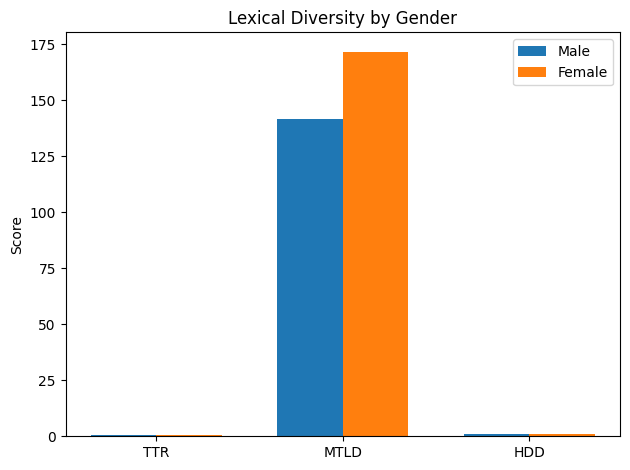

In [102]:
import matplotlib.pyplot as plt

labels = list(male_div.keys())
male_scores = list(male_div.values())
female_scores = list(female_div.values())

x = range(len(labels))
width = 0.35

plt.bar(x, male_scores, width=width, label='Male')
plt.bar([i + width for i in x], female_scores, width=width, label='Female')
plt.xticks([i + width / 2 for i in x], labels)
plt.ylabel("Score")
plt.title("Lexical Diversity by Gender")
plt.legend()
plt.tight_layout()
plt.show()


In [103]:
# Quantitative Objective Text Metric: Readability Scores

In [104]:
import textstat
import pandas as pd

# Group all prompts together by gender
def get_combined_prompts(df, gender):
    gender_df = df[df['gender'] == gender]
    combined_text = " ".join(
        gender_df['prompt1'].astype(str).tolist() +
        gender_df['prompt2'].astype(str).tolist() +
        gender_df['prompt3'].astype(str).tolist()
    )
    return combined_text

male_text = get_combined_prompts(df, 'Male')
female_text = get_combined_prompts(df, 'Female')


# Compute readability metrics
def get_readability_metrics(text):
    return {
        'Flesch Reading Ease': textstat.flesch_reading_ease(text),
        'Flesch-Kincaid Grade': textstat.flesch_kincaid_grade(text),
        'Gunning Fog Index': textstat.gunning_fog(text),
        'SMOG Index': textstat.smog_index(text),
        'Automated Readability Index': textstat.automated_readability_index(text),
        'Dale-Chall Score': textstat.dale_chall_readability_score(text)
    }

male_readability = get_readability_metrics(male_text)
female_readability = get_readability_metrics(female_text)

# Display results
print("📘 Readability Scores - Male:\n", male_readability)
print("\n📗 Readability Scores - Female:\n", female_readability)


📘 Readability Scores - Male:
 {'Flesch Reading Ease': 67.39493736679574, 'Flesch-Kincaid Grade': 8.325407768257143, 'Gunning Fog Index': 10.990532527220797, 'SMOG Index': 11.20814326018867, 'Automated Readability Index': 8.601991773215506, 'Dale-Chall Score': 8.9101091659055}

📗 Readability Scores - Female:
 {'Flesch Reading Ease': 70.25535283905232, 'Flesch-Kincaid Grade': 7.6168183210784335, 'Gunning Fog Index': 10.349060457516341, 'SMOG Index': 10.718039707386858, 'Automated Readability Index': 7.6068652119732505, 'Dale-Chall Score': 8.537267871732027}


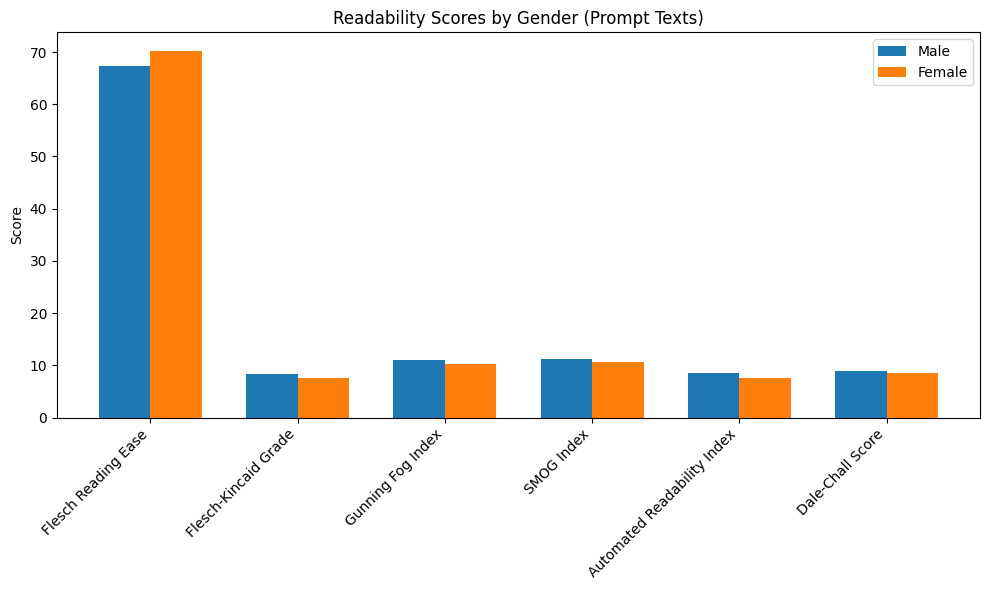

In [105]:
import matplotlib.pyplot as plt

labels = list(male_readability.keys())
x = range(len(labels))
male_scores = list(male_readability.values())
female_scores = list(female_readability.values())

width = 0.35
plt.figure(figsize=(10, 6))
plt.bar(x, male_scores, width, label='Male')
plt.bar([i + width for i in x], female_scores, width, label='Female')
plt.xticks([i + width / 2 for i in x], labels, rotation=45, ha='right')
plt.ylabel('Score')
plt.title('Readability Scores by Gender (Prompt Texts)')
plt.legend()
plt.tight_layout()
plt.show()


In [106]:
# Sentiment analysis

In [107]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
def get_sentiment_scores(text):
    scores = analyzer.polarity_scores(text)
    return scores['compound']  # Compound is overall sentiment: [-1, 1]


In [108]:
df['Prompt1_sentiment'] = df['prompt1'].astype(str).apply(get_sentiment_scores)
df['Prompt2_sentiment'] = df['prompt2'].astype(str).apply(get_sentiment_scores)
df['Prompt3_sentiment'] = df['prompt3'].astype(str).apply(get_sentiment_scores)


In [109]:
sentiment_by_gender = df.groupby('gender')[[
    'Prompt1_sentiment',
    'Prompt2_sentiment',
    'Prompt3_sentiment'
]].mean()

print(sentiment_by_gender)


        Prompt1_sentiment  Prompt2_sentiment  Prompt3_sentiment
gender                                                         
Female           0.395306           0.488306           0.706212
Male             0.463157           0.535522           0.728230


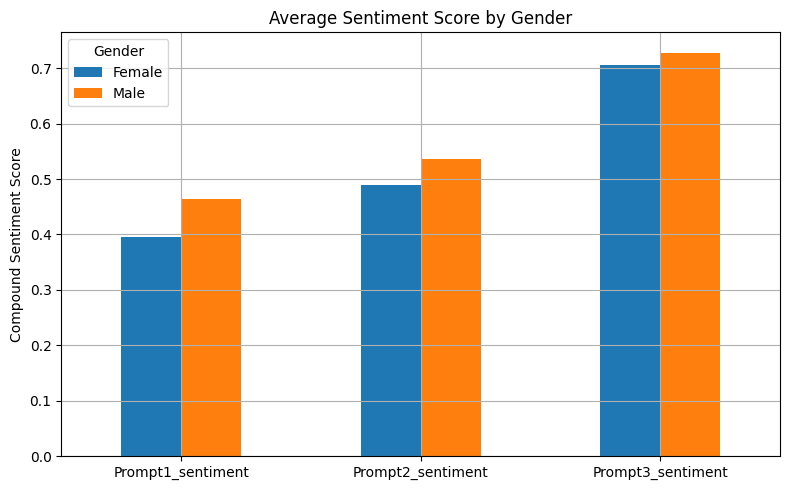

In [110]:
import matplotlib.pyplot as plt

sentiment_by_gender.T.plot(kind='bar', figsize=(8, 5))
plt.title('Average Sentiment Score by Gender')
plt.ylabel('Compound Sentiment Score')
plt.xticks(rotation=0)
plt.legend(title='Gender')
plt.grid(True)
plt.tight_layout()
plt.show()


In [111]:
# Term Frequency-Inverse Document Frequency (TF-IDF) 

In [112]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd


In [113]:
df['All_Prompts'] = df[['prompt1', 'prompt2', 'prompt3']].astype(str).agg(' '.join, axis=1)


In [114]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=50)  # limit to top 50 terms
tfidf_matrix = vectorizer.fit_transform(df['All_Prompts'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())


In [115]:
mean_tfidf = tfidf_df.mean().sort_values(ascending=False)
print(mean_tfidf.head(10))  # Top 10 important words


want       0.153052
plan       0.143405
like       0.138497
dream      0.137886
write      0.130484
year       0.124472
house      0.122154
2025       0.121617
germany    0.121422
home       0.117034
dtype: float64


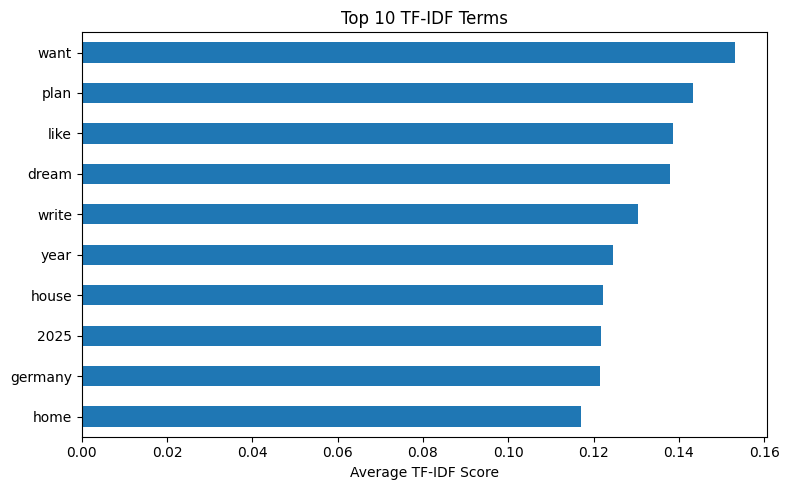

In [116]:
import matplotlib.pyplot as plt

mean_tfidf.head(10).plot(kind='barh', title='Top 10 TF-IDF Terms', figsize=(8, 5))
plt.xlabel('Average TF-IDF Score')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [117]:
# Group-wise mean TF-IDF
df_male = df[df['gender'] == 'Male']['All_Prompts']
df_female = df[df['gender'] == 'Female']['All_Prompts']

# Re-vectorize separately
tfidf_male = vectorizer.fit_transform(df_male)
tfidf_female = vectorizer.fit_transform(df_female)

tfidf_male_df = pd.DataFrame(tfidf_male.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_female_df = pd.DataFrame(tfidf_female.toarray(), columns=vectorizer.get_feature_names_out())

# Mean TF-IDF by gender
mean_male = tfidf_male_df.mean().sort_values(ascending=False)
mean_female = tfidf_female_df.mean().sort_values(ascending=False)

# View top terms per gender
print("Top Male TF-IDF terms:\n", mean_male.head(10))
print("Top Female TF-IDF terms:\n", mean_female.head(10))


Top Male TF-IDF terms:
 want     0.149019
ll       0.144322
essay    0.143753
plan     0.143312
like     0.139542
write    0.125998
life     0.123701
house    0.121362
2025     0.117564
year     0.116971
dtype: float64
Top Female TF-IDF terms:
 want       0.161420
plan       0.144219
year       0.141896
write      0.139362
2025       0.133323
like       0.129906
dream      0.128190
germany    0.120806
essay      0.109053
days       0.108623
dtype: float64


In [118]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt

# Create gender-specific prompt texts
df['All_Prompts'] = df[['prompt1', 'prompt2', 'prompt3']].astype(str).agg(' '.join, axis=1)
male_texts = df[df['gender'] == 'Male']['All_Prompts']
female_texts = df[df['gender'] == 'Female']['All_Prompts']

# Initialize vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=30)  # You can adjust max_features

# Fit and transform each group
tfidf_male = vectorizer.fit_transform(male_texts)
male_terms = vectorizer.get_feature_names_out()
male_scores = tfidf_male.mean(axis=0).A1
male_df = pd.Series(male_scores, index=male_terms).sort_values(ascending=False)

tfidf_female = vectorizer.fit_transform(female_texts)
female_terms = vectorizer.get_feature_names_out()
female_scores = tfidf_female.mean(axis=0).A1
female_df = pd.Series(female_scores, index=female_terms).sort_values(ascending=False)


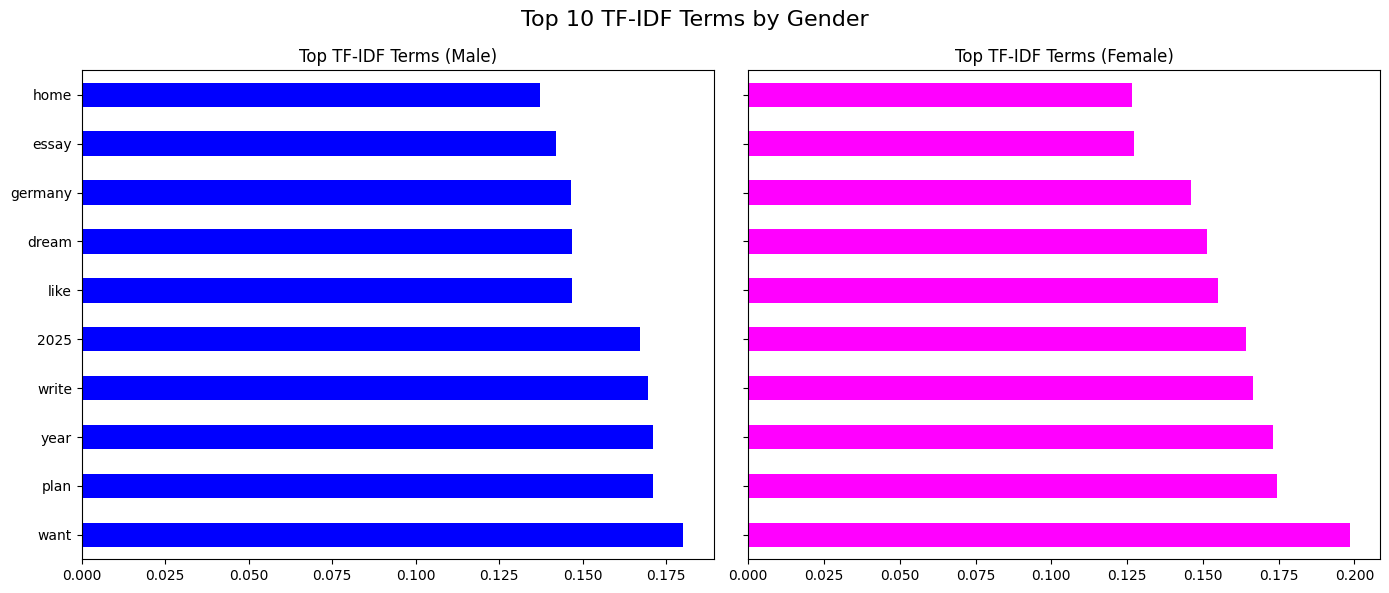

In [119]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Male
male_df.head(10).plot(kind='barh', ax=axes[0], color='blue')
axes[0].set_title('Top TF-IDF Terms (Male)')
axes[0].invert_yaxis()

# Female
female_df.head(10).plot(kind='barh', ax=axes[1], color='magenta')
axes[1].set_title('Top TF-IDF Terms (Female)')

plt.suptitle("Top 10 TF-IDF Terms by Gender", fontsize=16)
plt.tight_layout()
plt.show()


In [120]:
# Gramatical Mistake

   gender  Total_Mistakes
0  Female        5.176471
1    Male        7.594595


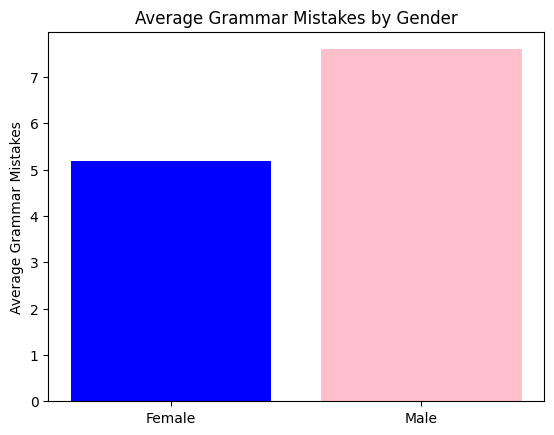

In [121]:
import language_tool_python
import pandas as pd
import matplotlib.pyplot as plt

# Initialize grammar checking tool
tool = language_tool_python.LanguageTool('en-US')

def count_grammar_mistakes(text):
    matches = tool.check(text)
    return len(matches)

# Apply grammar check to each prompt (case-sensitive column names)
for prompt_col in ['prompt1', 'prompt2', 'prompt3']:
    df[f'{prompt_col}_Mistakes'] = df[prompt_col].astype(str).apply(count_grammar_mistakes)

# Sum mistakes for each participant (keep lowercase)
df['Total_Mistakes'] = df[['prompt1_Mistakes', 'prompt2_Mistakes', 'prompt3_Mistakes']].sum(axis=1)

# Compare average mistakes by gender
mistake_summary = df.groupby('gender')['Total_Mistakes'].mean().reset_index()

# Print summary
print(mistake_summary)

# Visualization
plt.bar(mistake_summary['gender'], mistake_summary['Total_Mistakes'], color=['blue', 'pink'])
plt.ylabel('Average Grammar Mistakes')
plt.title('Average Grammar Mistakes by Gender')
plt.show()


In [122]:
# length of the prompt

In [123]:
# Function to count words in a text
def word_count(text):
    return len(str(text).split())

# Calculate total word count for each participant across all prompts
df['total_prompt_length'] = (
    df['prompt1'].apply(word_count) +
    df['prompt2'].apply(word_count) +
    df['prompt3'].apply(word_count)
)

# Group by gender and get the average length
length_summary = df.groupby('gender')['total_prompt_length'].mean().reset_index()

# Identify which gender writes the longest prompts
winner = length_summary.loc[length_summary['total_prompt_length'].idxmax()]

print(length_summary)
print(f"\nGender that writes the longest prompts on average: {winner['gender']} ({winner['total_prompt_length']} words)")


   gender  total_prompt_length
0  Female           151.176471
1    Male           135.513514

Gender that writes the longest prompts on average: Female (151.1764705882353 words)


In [136]:
# Coherence analysis

Loading Sentence Transformer model. This may take a moment...
Model loaded successfully.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]


Coherence Scores per Task:
------------------------------
Average Coherence (Task 1): 0.6665
Average Coherence (Task 2): 0.7198
Average Coherence (Task 3): 0.7177

DataFrame with Coherence Scores:
------------------------------
                                             prompt1  \
0  "I think 2025 is a year of fast technology gro...   
1  Write a brief reflection on how you feel about...   
2  The Year 2025: A Time of Hope and Uncertainty\...   
3  write an essay for me that how my 2025 went, I...   
4  Make an essay from this:\n2025 started with a ...   

                                           response1  coherence_score_t1  \
0  The year 2025 is marked by rapid technological...            0.761855   
1  The year 2025 marks a new chapter in human pro...            0.466612   
2  However, not everything is bright. Economic in...            0.516662   
3  The year 2025 has been one of the most transfo...            0.723944   
4  Reflecting on 2025: A Year of Growth and Balan...  

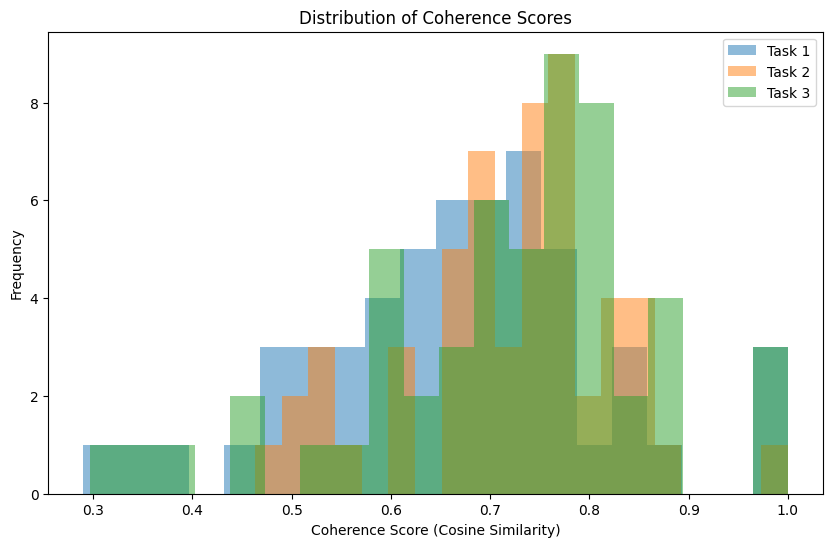

In [135]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import re
import numpy as np

# ---  Load a pre-trained Sentence Transformer model ---
# This model converts text into numerical vectors (embeddings) that capture semantic meaning.
print("Loading Sentence Transformer model. This may take a moment...")
# The 'device' parameter is added to force the model to use the CPU, which avoids the CUDA error.
model = SentenceTransformer('all-MiniLM-L6-v2', device='cpu')
print("Model loaded successfully.")

# --- 2. Define a function to calculate the coherence score ---
def calculate_coherence(prompts, responses):
    """
    Calculates the cosine similarity between a list of prompts and their responses.
    This serves as a proxy for semantic coherence.
    
    Args:
        prompts (pd.Series): A pandas Series containing the prompt texts.
        responses (pd.Series): A pandas Series containing the response texts.
        
    Returns:
        np.ndarray: A NumPy array of cosine similarity scores.
    """
    # Replace NaN values with empty strings to prevent errors during embedding
    prompts_clean = prompts.fillna("").tolist()
    responses_clean = responses.fillna("").tolist()

    # Encode the texts into vector embeddings
    prompt_embeddings = model.encode(prompts_clean, show_progress_bar=True)
    response_embeddings = model.encode(responses_clean, show_progress_bar=True)

    # Calculate the cosine similarity for each pair of prompt/response
    # Reshape the vectors to be able to apply element-wise dot product
    prompt_embeddings_reshaped = prompt_embeddings.reshape(prompt_embeddings.shape[0], -1)
    response_embeddings_reshaped = response_embeddings.reshape(response_embeddings.shape[0], -1)

    # Calculate and return the diagonal of the similarity matrix, which
    # represents the similarity of each prompt to its corresponding response.
    coherence_scores = np.diag(cosine_similarity(prompt_embeddings_reshaped, response_embeddings_reshaped))
    return coherence_scores

# --- 3. Run the coherence analysis for all three prompt/response pairs ---

# Task 1
df['coherence_score_t1'] = calculate_coherence(df['prompt1'], df['response1'])

# Task 2
df['coherence_score_t2'] = calculate_coherence(df['prompt2'], df['response2'])

# Task 3
df['coherence_score_t3'] = calculate_coherence(df['prompt3'], df['response3'])

# --- 4. Display the results ---

print("\nCoherence Scores per Task:")
print("-" * 30)
print(f"Average Coherence (Task 1): {df['coherence_score_t1'].mean():.4f}")
print(f"Average Coherence (Task 2): {df['coherence_score_t2'].mean():.4f}")
print(f"Average Coherence (Task 3): {df['coherence_score_t3'].mean():.4f}")

# You can also view the new columns in your DataFrame.
# The `head()` function shows the first 5 rows.
print("\nDataFrame with Coherence Scores:")
print("-" * 30)
print(df[['prompt1', 'response1', 'coherence_score_t1',
          'prompt2', 'response2', 'coherence_score_t2',
          'prompt3', 'response3', 'coherence_score_t3']].head())

# --- 5. Optional: Deeper analysis and visualization ---
# You can use visualization libraries like matplotlib or seaborn to explore the data.
# For example, to plot a histogram of the scores:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(df['coherence_score_t1'], bins=20, alpha=0.5, label='Task 1')
plt.hist(df['coherence_score_t2'], bins=20, alpha=0.5, label='Task 2')
plt.hist(df['coherence_score_t3'], bins=20, alpha=0.5, label='Task 3')
plt.title('Distribution of Coherence Scores')
plt.xlabel('Coherence Score (Cosine Similarity)')
plt.ylabel('Frequency')
plt.legend()
plt.show()
